# Distributed Joblib

Scikit-learn already parallelizes many algorithms internally using `joblib`.
You can schedule these to run on a distributed cluster using `dask.distributed`, which register's a plugin with `joblib.`

Parts of this example are taken from https://github.com/ogrisel/parallel_ml_tutorial/blob/master/notebooks/06%20-%20Distributed%20Model%20Selection%20and%20Assessment.ipynb

In [1]:
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib

import distributed.joblib
from distributed import Client

As usual, we connect to our client. Typically you would be the address for your scheduler here.

In [2]:
client = Client()

Let's load the data as usual.

In [3]:
# Load the faces dataset

data = fetch_olivetti_faces()
X = data.images.reshape((len(data.images), -1))
y = data.target

mask = y < 5  # Limit to 5 classes
X = X[mask]
y = y[mask]

And create the classifier.

In [4]:
forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features=128,
                              n_jobs=-1,
                              random_state=0)

And now we fit the model. The actual fitting step is the usual `forest.fit(X, y)`.
To use our cluster, we'll use the `joblib.parallel_backend` context manager.

In [6]:
# Build a forest and compute the pixel importances

t0 = time()
with joblib.parallel_backend('dask.distributed', scheduler_host=client.scheduler.address):
    forest.fit(X, y)
    
print("done in %0.3fs" % (time() - t0))

done in 1.106s


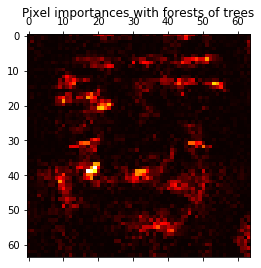

In [7]:
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees")
plt.show()